In [1]:
import sys
sys.path.append('/home/chris/repos/financial_analysis/')
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from credentials import *

### Testing the Alpha Vantage API by pulling DAX data

In [3]:
import requests
import json
import pprint

url = "https://www.alphavantage.co/query"
outFile = '../newfile.csv'
function = "TIME_SERIES_DAILY"
symbol = "^GDAXI"
api_key = key

data = { "function": function, 
         "symbol": symbol, 
         "apikey": api_key,
         "outputsize": 'compact',
         "datatype": 'csv'} 
page = requests.get(url, params = data)
#pprint.pprint(page.json())

with open(outFile, 'w') as oF:
    oF.write(page.text)

In [4]:
dax = 'DAX'
df = pd.read_csv('../newfile.csv',usecols=["timestamp", "close"]).rename(columns={'close' : 'close_'+dax})

In [5]:
df.head(n=5)

,timestamp,close_DAX
0,2018-03-09,12346.6797
1,2018-03-08,12355.5703
2,2018-03-07,12245.3604
3,2018-03-06,12113.8701
4,2018-03-05,12090.8701


In [6]:
df.loc[(df==0).any(axis=1)].index

Int64Index([90], dtype='int64')

In [7]:
df = df.drop(df.loc[(df==0).any(axis=1)].index)
df = df.iloc[::-1]

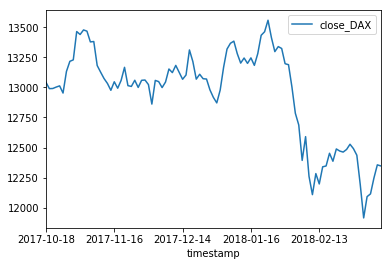

In [8]:
df.plot(x='timestamp',y='close_DAX')

### Now pull a bunch of relevant indices

* Plot time series
* Plot their correlations

In [150]:
indices = [
    '^GDAXI',#DAX
    '^GSPC', #S&P 500
    '^DJI',  #DowJones 30
    #'^IXIC', #NASDAQ
    '^NYA', #NYSE COMPOSITE (DJ)
    '^XAX',  #NYSE AMEX COMPOSITE INDEX
    #'^BATSK',#BATS 1000 Index
    '^RUT',  #Russell 2000
    '^VIX',  #Vix
    '^FTSE', #FTSE 100
    '^FCHI', #CAC 40
    '^STOXX50E', #STOXX 50
    '^N100', #EURONEXT 100
    '^BFX',  #BEL 20 Brussels
    '^N225', #Nikkei
    '^HSI'  #Hangseng
'''    '^TA100',#TA-125
    '^MXX', #IPC Mexico
    '^GSPTSE', #S&P/TSX Composite index
    '^NZ50' #S&P/NZX 50 INDEX GROSS'''
    
    
    
    
]

In [151]:
url = "https://www.alphavantage.co/query"
index_data_dir = '../data/'
function = "TIME_SERIES_DAILY"
symbol = "^GDAXI"
api_key = key

for index in indices:
    data = { "function": function, 
         "symbol": index, 
         "apikey": api_key,
         #"outputsize": 'compact',
         "datatype": 'csv'} 
    page = requests.get(url, params = data)
    with open(index_data_dir + 'data_' + index.strip('^') + '.csv', 'w') as oF:
        oF.write(page.text)

FileNotFoundError: [Errno 2] No such file or directory: "../data/data_    '^TA100',#TA-125\n    '^MXX', #IPC Mexico\n    '^GSPTSE', #S&P/TSX Composite index\n    '^NZ50' #S&P/NZX 50 INDEX GROSS.csv"

In [ ]:
import glob

allFiles = glob.glob(index_data_dir + "*.csv")
df_indices = pd.DataFrame()
list_ = []
for file_ in allFiles:
    name = str(str(file_).split('_')[1]).split('.')[0]
    print(name)
    #Drop redundant timestamps
    df = pd.read_csv(file_,usecols=["timestamp", "close"]).rename(columns={'timestamp' : 'timestamp_'+name, 'close' : 'close_'+name})
    #df = df.drop(df.loc[(df==0).any(axis=1)].index)    
    list_.append(df)
df_indices = pd.concat(list_, axis=1)
df_indices = df_indices.iloc[::-1]
df_indices = df_indices.drop(df_indices.loc[(df_indices==0).any(axis=1)].index)  

In [ ]:
df_indices.head(n=4)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_indices = df_indices.filter(regex='close', axis=1)


plt.figure(figsize=(10,10))
plt.title('Correlation: Indices', y=1.05, size=15)
plot = sns.heatmap(df_indices.corr(), xticklabels=df_indices.columns, yticklabels=df_indices.columns,  linewidths=0.1,vmax=1.0,vmin=0, square=True, linecolor='white')
#plot.set_xticklabels(plot.get_xticklabels(),rotation=30)
#plot.set_ylabel('')
#plot.set_xlabel('')
plt.setp(plot.get_xticklabels(), rotation=45)
plt.setp(plot.get_yticklabels(), rotation=0)

plt.show()



### First simple predictive model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM,Dense

In [ ]:
np.random.seed(7)

In [ ]:
df_indices = df_indices.fillna(0)
df_indices = df_indices.drop(df_indices.loc[(df_indices==0).any(axis=1)].index)
#df_indices = scaler.fit_transform(df_indices.filter(regex='close'))

In [ ]:
#Define asset to be predicted
predicted_asset = 'close_RUT'
asset_position = list(df_indices.columns).index(predicted_asset)
print(asset_position)

In [ ]:
#df_indices.close_GDAXI

In [ ]:
plt.plot(df_indices[predicted_asset])

In [ ]:
cols = list(df_indices)
cols.insert(0, cols.pop(cols.index(predicted_asset)))
df_indices = df_indices.loc[:, cols]

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
 # load dataset
dataset = df_indices
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, df_indices.shape[1]+1:reframed.shape[1]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
reframed.shape,df_indices.shape

In [ ]:
reframed.shape, df_indices.shape, values.shape

In [ ]:
# split into train and test sets
values = reframed.values
train = values[:30, :]
test = values[30:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dense(1, activation='softmax'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X.reshape((test_X.shape[0], test_X.shape[2]))[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [ ]:
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

In [ ]:
yhat = model.predict(test_X)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(inv_yhat)

In [ ]:
historic = np.array(df_indices[predicted_asset])
future = inv_yhat
prediction = np.append(historic,future)  

In [ ]:
plt.axvline(x=len(historic), linestyle='--', color='red')
plt.plot(prediction)

In [ ]:
future[0]